In [1]:
!pip install pymupdf Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 97.2 MB/s eta 0:00:00


In [2]:
!pip install transformers timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.1 MB/s eta 0:00:00


In [4]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 73.3 MB/s eta 0:00:00


In [20]:
!pip install transformers

In [22]:
import faiss
import numpy as np
import torch
import fitz  # used for text and image extraction from PDF
from transformers import CLIPProcessor, CLIPModel, BlipForConditionalGeneration, BlipProcessor
from transformers import T5ForConditionalGeneration, T5Tokenizer
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import re  # For NLP preprocessing
import pandas as pd  # feedback in a DataFrame
import textwrap  # formatting paragraphs for easier reading
from google.colab import files

In [23]:
file_input = files.upload() #upload file using google colabs upload method

Saving Task 2 - AI intern.pdf to Task 2 - AI intern (15).pdf


In [24]:
pdf_path = list(file_input.keys())[0] # path to the uploaded file

In [26]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32") # used for both text and images
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [27]:
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-vqa-base")
# multimodal processor for answer generation for user queries

In [28]:
# additional summarization using another LLM for better answer
t5_model = T5ForConditionalGeneration.from_pretrained("t5-large")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-large")

In [29]:
feedback_df = pd.DataFrame(columns=["Retrieved_Texts", "Retrieved_Image", "Summary", "User_Feedback"])

In [30]:
def torch_to_numpy(tensor):
    return tensor.detach().cpu().numpy().astype('float32')
# torch to numpy array converter function

In [31]:
def preprocess_text(text):
    # remove bullet points, extra newlines, or unusual characters
    text = re.sub(r'[\u2022•●·]', '', text)  #  bullet points removal
    text = re.sub(r'\n+', ' ', text)  # new lines removal
    text = re.sub(r'[^A-Za-z0-9.,!? ]+', '', text)
    text = text.strip()
    return text

In [39]:
def extraction(pdf_path):
    textlist = []
    imageslist = []

    # Open the PDF file
    pdf_document = fitz.open(pdf_path)

    for page_number in range(len(pdf_document)):
        page = pdf_document.load_page(page_number)

        # Extract text and preprocess it
        text = page.get_text("text")
        if text.strip():  # If there's any non-empty text, append after preprocessing
            clean_text = preprocess_text(text)
            textlist.append(clean_text)

        # Extract images
        images = page.get_images(full=True)
        for img in images:
            xref = img[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(BytesIO(image_bytes))
            imageslist.append(image)

    pdf_document.close()

    print(f"Extracted {len(textlist)} texts and {len(textlist)} images from the PDF.")
    return textlist, imageslist

In [40]:
def split_text_into_chunks(text, max_chunk_size=77):
    # tokenize the text using the CLIP tokenizer
    inputs = clip_processor.tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = inputs["input_ids"][0]

    # split the tokenized input into chunks
    chunks = [input_ids[i: i + max_chunk_size] for i in range(0, len(input_ids), max_chunk_size)]

    # decode chunks back into text
    chunked_texts = [clip_processor.tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]
    return chunked_texts

In [55]:
def embed_text_in_chunks(texts):
    all_embeddings = []

    for text in texts:
        # split text into chunks to be embedded
        text_chunks = split_text_into_chunks(text)

        # embedding individually
        for chunk in text_chunks:
            inputs = clip_processor(text=chunk, return_tensors="pt", padding=True, truncation=True)
            chunk_embedding = clip_model.get_text_features(**inputs)
            all_embeddings.append(chunk_embedding)

    # store all embeddings into one tensor to then flatten into a 2D array
    all_embeddings = torch.cat(all_embeddings, dim=0)
    return all_embeddings


In [42]:
def embed_images(images):
    inputs = clip_processor(images=images, return_tensors="pt")
    image_embeddings = clip_model.get_image_features(**inputs)
    return image_embeddings
    # basic image embedding using CLIP

In [43]:
def store_text_embeddings(text_embeddings, text_index):
    text_embeddings_np = torch_to_numpy(text_embeddings)
    print(f"Storing {text_embeddings_np.shape[0]} text embeddings in Faiss.")
    text_index.add(text_embeddings_np)
    # storing the embeddings in a multimodal vector space

def store_image_embeddings(image_embeddings, image_index, image_mapping):
    image_embeddings_np = torch_to_numpy(image_embeddings)
    print(f"Storing {image_embeddings_np.shape[0]} image embeddings in Faiss.")
    image_index.add(image_embeddings_np)
    # mapping each embedding with the actual image so we can retrieve it easily
    image_mapping.extend(image_embeddings_np)

In [44]:
def retrieve_similar(query_embedding, index, k=5):
    query_np = torch_to_numpy(query_embedding)
    distances, indices = index.search(query_np, k)

    return indices, distances
# using the euclidean distance to retrive the top semantically similar embeddings

In [45]:
def process_pdf_and_store_in_faiss(pdf_path, text_index, image_index, image_mapping):
    # text and images extractionfrom the PDF
    texts, images = extraction(pdf_path)

    # emebed the text and images
    text_embeddings = embed_text_in_chunks(texts)
    image_embeddings = embed_images(images)

    # store it in faiss index
    store_text_embeddings(text_embeddings, text_index)
    store_image_embeddings(image_embeddings, image_index, image_mapping)

    return texts, images

In [46]:
# summarization for a better output
def summarize_text_t5(text):
    # preprocess the text for summarization
    inputs = t5_tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)

    # summary with fine-tuned parameters
    summary_ids = t5_model.generate(
        inputs,
        max_length=300,  # high max length for detailed summaries
        min_length=100,  # min length for depth
        length_penalty=2.0,  # penalty if its too long
        num_beams=4,  # for accuracy
        repetition_penalty=1.5,  # penalty to reduce repetition in the answer
        early_stopping=True
    )

    summary = t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [47]:
def generate_image_caption(image):
    inputs = blip_processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values']
    out = blip_model.generate(pixel_values=pixel_values, max_new_tokens=50)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    return caption
    # image caption generation so blip can effective answer the questions regarding the images

In [48]:
def generate_answer_with_caption(caption, text, image, max_new_tokens=50):
    combined_input = f"The image shows: {caption}. {text}"
    inputs = blip_processor(text=combined_input, images=image, return_tensors="pt")
    out = blip_model.generate(**inputs, max_new_tokens=max_new_tokens)
    answer = blip_processor.decode(out[0], skip_special_tokens=True)
    return answer
    # the answer returned has the caption that blip generated for better context

In [49]:
# auto checking feedback loop
def feedback_loop_auto(answer, feedback_df):
    # if the answer is too short
    word_count = len(answer.split())

    # repeated phrases
    repeated_phrases = len(set(answer.split())) < len(answer.split()) * 0.75  # random threshold

    # feedback based on these conditions
    if word_count < 50 or repeated_phrases:
        user_feedback = "incorrect"
        print("Feedback: The generated answer is too short or contains repetition.")
    else:
        user_feedback = "correct"
        print("Feedback: The generated answer is good.")

    # Log feedback in the DataFrame
    feedback_row = {
        "Summary": answer,
        "User_Feedback": user_feedback
    }
    feedback_row_df = pd.DataFrame([feedback_row])
    feedback_df = pd.concat([feedback_df, feedback_row_df], ignore_index=True)

    # feedback_df.to_csv("feedback_log.csv", index=False)
    return feedback_df

In [51]:
def query_faiss_for_text_and_images(user_query, text_index, image_index, texts, image_mapping, images, feedback_df):
    # emebedding the query and then doing smeantic retrieval
    query_embedding = embed_text_in_chunks([user_query])
    retrieved_text_indices, retrieved_text_distances = retrieve_similar(query_embedding, text_index, k=5)
    retrieved_image_indices, retrieved_image_distances = retrieve_similar(query_embedding, image_index, k=1)

    # display retrieved text results without duplicity
    retrieved_texts = []
    print("\nRetrieved Texts:")
    for idx in np.unique(retrieved_text_indices[0]):
        if idx < len(texts):
            print(f"Text {idx+1}: {texts[idx]}")
            retrieved_texts.append(texts[idx])

    # concatenate all the retrieved inputs
    if len(retrieved_texts) > 1:
        combined_text = " ".join(retrieved_texts[:2])  # Combine first two retrieved texts
    else:
        combined_text = retrieved_texts[0]

    # display the image
    print("\nRetrieved Images:")
    retrieved_image = None
    for idx in retrieved_image_indices[0]:
        if idx < len(image_mapping):
            print(f"Image {idx+1} retrieved.")
            plt.imshow(images[idx])
            plt.axis('off')  # Turn off the axis
            plt.show()  # Display the image
            retrieved_image = images[idx]  # Store the retrieved image for answer generation


    # caption for the image in the document and combine it with the retrieved text for answer generation
    if combined_text and retrieved_image:
        print("\nGenerated Answer:")
        image_caption = generate_image_caption(retrieved_image)
        answer = generate_answer_with_caption(image_caption, combined_text, retrieved_image, max_new_tokens=100)

        print("\nAnswer before summarization:")
        print(textwrap.fill(answer, width=80))

        # summarize the answer using T5 model for better results
        summarized_answer = summarize_text_t5(answer)
        print("\nSummarized Answer:")
        print(textwrap.fill(summarized_answer, width=80))

        # feedback loop based on answer quality
        feedback_df = feedback_loop_auto(summarized_answer, feedback_df)

    return feedback_df


In [52]:
text_index = faiss.IndexFlatL2(512)  # Faiss index for text embeddings (512-dimensional for CLIP)
image_index = faiss.IndexFlatL2(512)  # Faiss index for image embeddings (512-dimensional for CLIP)
image_mapping = []

In [56]:
texts, images = process_pdf_and_store_in_faiss(pdf_path, text_index, image_index, image_mapping)

Extracted 2 texts and 2 images from the PDF.
Storing 5 text embeddings in Faiss.
Storing 1 image embeddings in Faiss.


In [57]:
user_query = input("Enter your query: ")

Enter your query: Describe the document and the image.



Retrieved Texts:
Text 1: Task Multimodal RAG application Goal Implement a multimodal query processing workflow that handles both text and image inputs, without relying on OCR for image content extraction. Utilise a multimodal large language model LLM to process retrieved text and images for generating responses. Objective Build a complete pipeline following the given workflow that supports multimodal content retrieval and generation. Extract both text and image content from documents and embed them into a shared multimodal vector space. Perform semantic retrieval based on user queries to fetch relevant text and image data. Feed retrieved images and texts into a multimodal LLM that generates an answer based on both types of input. Avoid using OCR for image processing instead, the images should be processed directly as part of the multimodal input to the LLM. The pipeline should be robust and capable of handling diverse user queries, reflecting the multimodal approach in every step.
Tex

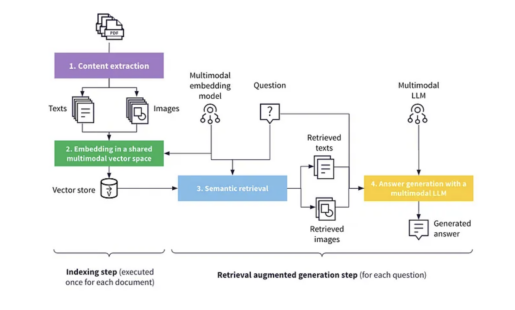


Generated Answer:

Answer before summarization:
the image shows : it is called it's flow. task multimodal rag application goal
implement a multimodal query processing workflow that handles both text and
image inputs, without relying on ocr for image content extraction. utilise a
multimodal large language model llm to process retrieved text and images for
generating responses. objective build a complete pipeline following the given
workflow that supports multimodal content retrieval and generation. extract both
text and image content from documents and embed them into a shared multimodal
vector space. perform semantic retrieval based on user queries to fetch relevant
text and image data. feed retrieved images and texts into a multimodal llm that
generates an answer based on both types of input. avoid using ocr for image
processing instead, the images should be processed directly as part of the
multimodal input to the llm. the pipeline should be robust and capable of
handling diverse us

In [58]:
feedback_df = query_faiss_for_text_and_images(user_query, text_index, image_index, texts, image_mapping, images, feedback_df)